# 🥐 2024 Dozen Bakery Sales Analysis 🥐

In [637]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as npa
import re
from datetime import time
import glob
from matplotlib.colors import ListedColormap
pd.set_option('display.max_columns', None) 


# 🎨

In [640]:
doz_pal= [ "#011e41", "#6f1f2a", "#074237", "#f4bd24", "#e68a78", "#e92e2a", 
        "#a0c9db", "#d6d2c5", "#f2e0e7"]

doz_diz = [ "coolwarm"    
          ]

# DATA 

In [643]:
file_pattern = '/Users/jonathanfarro/Documents/Dozen Bakery Project/Dozen Sales 2024/*.csv'

all_files = glob.glob(file_pattern)

all_df = [pd.read_csv(file) for file in all_files]

combined_df = pd.concat(all_df, ignore_index=True)

df = combined_df

combined_df.head(1)



,Date,Time,Time Zone,Category,Item,Qty,Price Point Name,SKU,Modifiers Applied,Gross Sales,Discounts,Net Sales,Tax,Transaction ID,Payment ID,Device Name,Notes,Details,Event Type,Location,Dining Option,Customer ID,Customer Name,Customer Reference ID,Unit,Count,Itemization Type,Fulfillment Note,Channel,Token
0,2024-03-31,14:26:15,Central Time (US & Canada),Retail,Cheese,1.0,Cheddar Snack Stix,NaN,NaN,$2.00,-$0.50,$1.50,$0.14,bBaPy5nkh9l7FYXTmyHAvL2eV,PzIDRyFLY6CTUFSLGavkybx7taB,Claire,NaN,https://app.squareup.com/dashboard/sales/trans...,Payment,Dozen,To Go,3KBXWH0PQ1BFZ46EKW8D59EFPW,J Hunt,NaN,ea,1,Physical Good,NaN,Dozen,I5K5R2GM3ORMXA5E77KSVXEK


# Cleaning

In [645]:
df = df.rename(columns=lambda x: x.lower())

df = df.map(lambda x: x.lower() if isinstance(x, str) else x).reset_index(drop=True)

#-------------------------------------------------------------------------------------

df['gross sales']=df['gross sales'].replace("[$,]", "", regex=True).astype(float)

#-------------------------------------------------------------------------------------

df['discounts']=df['discounts'].replace("[$,]", "", regex=True).astype(float)

#-------------------------------------------------------------------------------------

df['net sales']=df['net sales'].replace("[$,]", "", regex=True).astype(float)

#-------------------------------------------------------------------------------------

df['tax']=df['tax'].replace("[$,]", "", regex=True).astype(float)

df['date'] = pd.to_datetime(df['date'])

df['datetime'] = df['date'] + pd.to_timedelta(df['time'])


df['time_12hr'] = df['datetime'].dt.strftime('%I:%M %p')


#-------------------------------------------------------------------------------------


df.rename(columns= {'price point name':'desc','modifieres applied':'mods','datetime':'date_time'},inplace = True) 

#-------------------------------------------------------------------------------------
df = df.drop(columns=['date',
                        'time',
                        'time zone',
                        'sku',
                        'itemization type',
                        'token',])

#-------------------------------------------------------------------------------------
new_column_order = ['date_time', 
                    'time_12hr', 
                    'event type', 
                    'channel', 
                    'customer id', 
                    'customer name', 
                    'category', 
                    'item', 
                    'qty', 
                    'desc',
                    'modifiers applied', 
                    'gross sales', 
                    'discounts', 
                    'net sales', 
                    'tax', 
                    'notes']
#-------------------------------------------------------------------------------------

df = df[new_column_order]

#-------------------------------------------------------------------------------------

df = df.fillna(0)

#-------------------

df = df.rename(columns=lambda x: x.replace(' ', '_'))


In [646]:
df = df.drop(columns=['event_type','channel','customer_id'])

In [647]:
df['weekday'] = df['date_time'].dt.weekday
df['month'] = df['date_time'].dt.month_name()

In [648]:
df = df.sort_values(by='date_time').reset_index(drop=True)

In [649]:
df['date'] = df['date_time'].dt.date
df['time'] = df['date_time'].dt.time
df['hour'] = df['date_time'].dt.hour

In [650]:
#---------------------------------------------------------------------------

df[['category','item']] = df[['category','item']].replace('special orders - pastry','pastry')

df[['category','item']] = df[['category','item']].replace('pastries','pastry')

df['item'] = df['item'].replace('cookie','cookies') 

df['item'] = df['item'].replace('muffin','muffins') 
#---------------------------------------------------------------------------

df['category'] = df['category'].replace('special orders - bread','bread')

#---------------------------------------------------------------------------

df['category'] = df['category'].replace('special orders - retail','retail')

#---------------------------------------------------------------------------

df['category'] = df['category'].replace('staff bev','staff meal/bev')
df['category'] = df['category'].replace('staff meal','staff meal/bev')

#---------------------------------------------------------------------------

df = df.loc[~((df['category'] == 0))]

df= df[df['category'] != 'scuits popup']

#----- COMBINING DUPLICATE NAMES.
df['item'] = df['item'].replace('croissant (choc.)','croissant - chocolate')

df['item'] = df['item'].replace('croissant (almond)','croissant - almond')

df['item'] = df['item'].replace('croissant (plain)','croissant - plain')

df['item'] = df['item'].replace('croissant seasonal','croissant - seasonal')
df['item'] = df['item'].replace('croissant - seasonal (flavor changes monthly - see description)','croissant - seasonal')

df['item'] = df['item'].replace('croissant (ham & cheese)','croissant - ham & cheese')
df['item'] = df['item'].replace('croissant strata - ham and cheese','croissant - ham & cheese')
df['item'] = df['item'].replace('croissant - strata (h&c)','croissant - ham & cheese')

df['item'] = df['item'].replace('croissant (herb)','croissant - herb')

df['item'] = df['item'].replace('croissant - pull-aparts (mini or large)','croissant - pull-aparts')
df['item'] = df['item'].replace('croissant (pull-aparts)','croissant - pull-aparts')


df.discounts = df.discounts.astype(str)
df.discounts = df.discounts.str.replace('-','')
df.discounts = df.discounts.astype(float)

# 🍳 Egg Purchases Hourly Trends 🍳

In [652]:
def tag_orders_multiple_columns(df, columns):


   
    def contains_egg_in_row(row):
        for col in row.index:
            value = row[col]
            
            if pd.notna(value) and value != 0 and isinstance(value, str):
             if 'egg' in value.lower():
                    return True
        return False


    df['has_egg'] = df[columns].apply(contains_egg_in_row, axis=1)

    return df


columns_to_check = ['item', 'desc', 'category', 'notes', 'modifiers_applied']
df = tag_orders_multiple_columns(df, columns_to_check)


df[['item', 'desc', 'category', 'notes', 'modifiers_applied','has_egg']].head()



,item,desc,category,notes,modifiers_applied,has_egg
0,sandwich cookie,linzer,pastry,0,0,False
1,puzzles,piecework 1000 pc puzzle (assorted designs),retail,0,0,False
2,pastry,scone,pastry,0,0,False
3,pastry,croissant - almond,pastry,0,0,False
4,pastry,croissant - chocolate,pastry,0,0,False


In [653]:
df.columns

Index(['date_time', 'time_12hr', 'customer_name', 'category', 'item', 'qty',
       'desc', 'modifiers_applied', 'gross_sales', 'discounts', 'net_sales',
       'tax', 'notes', 'weekday', 'month', 'date', 'time', 'hour', 'has_egg'],
      dtype='object')

In [654]:
idf = df.set_index('date_time')


df_egg = idf.loc[
    (idf['has_egg'] == True) &  
    (idf['category'] != 'staff meal/bev') & 
    (idf['category'].isin(['breakfast', 'lunch'])) &
    (idf.index.hour >= 7) & (idf.index.hour < 15)
    ] 


df_egg = df_egg.reset_index()


group_egg = df_egg.groupby(['month','weekday','hour']).agg({'qty':'sum','net_sales':'sum'}).reset_index()

average_egg_orders_per_hour = group_egg.groupby(['weekday','hour']).agg({'qty':'mean'})
eggs_ph = average_egg_orders_per_hour
eggs_ph  = eggs_ph.reset_index().round(0).astype('int')



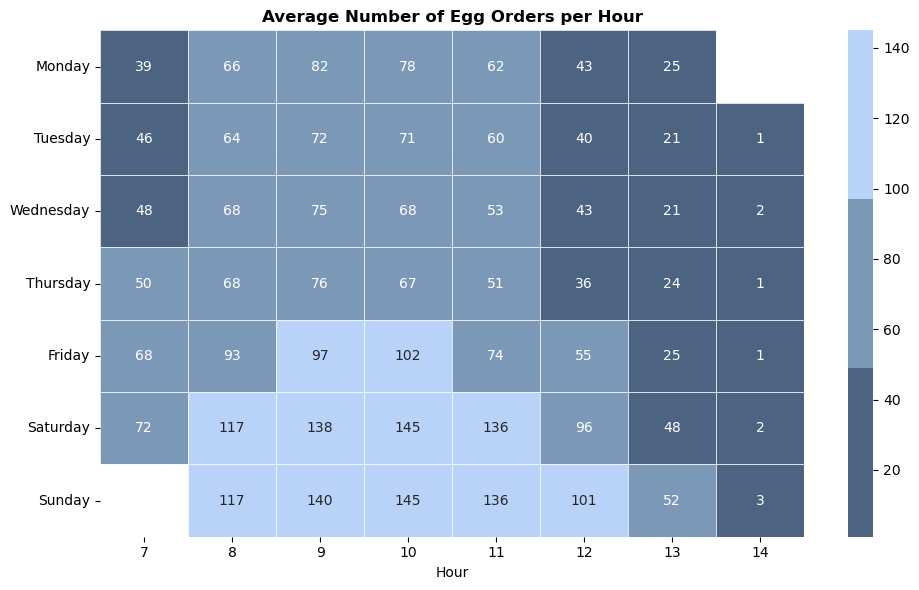

In [655]:

cobalt_blue_palette = ["#1f3c62", "#5a80a5", "#a6c8f5",]


pivot_df = eggs_ph.pivot(index='weekday', columns='hour', values='qty')


vmin = pivot_df.min().min()
vmax = pivot_df.max().max()


custom_cmap = ListedColormap(cobalt_blue_palette)


plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, cmap=custom_cmap, annot=True, fmt='g', 
            linewidths=0.5, vmin=vmin, vmax=vmax, yticklabels=weekday_names,alpha=.8)


plt.xticks( )
plt.xlabel('Hour')
plt.ylabel('',fontweight = 'bold')
plt.title('Average Number of Egg Orders per Hour',fontweight = 'bold')

plt.tight_layout()
###plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/eggs_heat_map.png')

In [656]:

extended_hours_weekdays = list(range(14, 19)) 


guesstimates = {}

for weekday in weekday_egg_averages['weekday'].unique():  
    sales_11am = weekday_egg_averages.loc[(weekday_egg_averages['weekday'] == weekday) & (weekday_egg_averages['hour'] == 11), 'qty'].values
    sales_10am = weekday_egg_averages.loc[(weekday_egg_averages['weekday'] == weekday) & (weekday_egg_averages['hour'] == 10), 'qty'].values

    if not sales_11am.size or not sales_10am.size:  # Skip if no data for 1 PM or 12 PM
        continue

    sales_11am = sales_11am[0]
    sales_10am = sales_10am[0]

    percentage_change = ((sales_11am - sales_10am) / sales_10am) * 100
    base_degradation = abs(percentage_change) / 100

    for hour in extended_hours_weekdays:
        hours_since_1pm = hour - 13

        # ***Increased Degradation Logic***
        degradation_factor = base_degradation * (2**hours_since_1pm)  # Exponential degradation
        degradation_factor = min(degradation_factor, 1)  # Cap at 100%

        low_degradation = degradation_factor
        medium_degradation = degradation_factor * 0.75  # Medium degradation (adjust as needed)
        high_degradation = degradation_factor * 0.5  # High degradation (adjust as needed)

        estimated_sales = sales_11am * (1 - np.array([low_degradation, medium_degradation, high_degradation]))

        guesstimates[(weekday, hour)] = {
            'low': estimated_sales[0],
            'medium': estimated_sales[1],
            'high': estimated_sales[2]
        }


heatmap_data = {}
levels = ['low', 'medium', 'high']

for level in levels:
    data = []
    for (weekday, hour), estimates in guesstimates.items():
        data.append({'weekday': weekday, 'hour': hour, 'qty': estimates[level]})

    # Create DataFrame and sort *before* pivoting
    heatmap_df = pd.DataFrame(data)  # Changed variable name to heatmap_df
    day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday'}
    heatmap_df['weekday_name'] = heatmap_df['weekday'].map(day_names)

    # Convert 'weekday_name' to a categorical type with ordered categories
    ordered_weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    heatmap_df['weekday_name'] = pd.Categorical(heatmap_df['weekday_name'], categories=ordered_weekdays, ordered=True)

    # Sort by the 'weekday_name' column to ensure proper order
    heatmap_df = heatmap_df.sort_values('weekday_name')

    heatmap_data[level] = heatmap_df.pivot_table(index='weekday_name', columns='hour', values='qty')


cobalt_blue_palette = ["#1f3c62", "#5a80a5", "#a6c8f5"]
custom_cmap = ListedColormap(cobalt_blue_palette)

for level, data in heatmap_data.items():
    plt.figure(figsize=(10, 6))
    sns.heatmap(data, cmap=custom_cmap, annot=True, fmt=".1f", linewidths=0.5, alpha=.8)
    plt.xlabel('Hour')
    plt.ylabel('')
    plt.title(f'Guesstimated Egg Demand ({level.capitalize()})', fontweight='bold')
    plt.yticks(rotation=0)
    plt.tight_layout()
     
    #plt.savefig(f'egg_prophet_{level}.png')
    
    # Close the plot to free up memory
    plt.close()


/var/folders/q1/g8w_03zs6gvbwv16kzb3fvk80000gn/T/ipykernel_1297/3188756838.py:59: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data[level] = heatmap_df.pivot_table(index='weekday_name', columns='hour', values='qty')
/var/folders/q1/g8w_03zs6gvbwv16kzb3fvk80000gn/T/ipykernel_1297/3188756838.py:59: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data[level] = heatmap_df.pivot_table(index='weekday_name', columns='hour', values='qty')
/var/folders/q1/g8w_03zs6gvbwv16kzb3fvk80000gn/T/ipykernel_1297/3188756838.py:59: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify obs

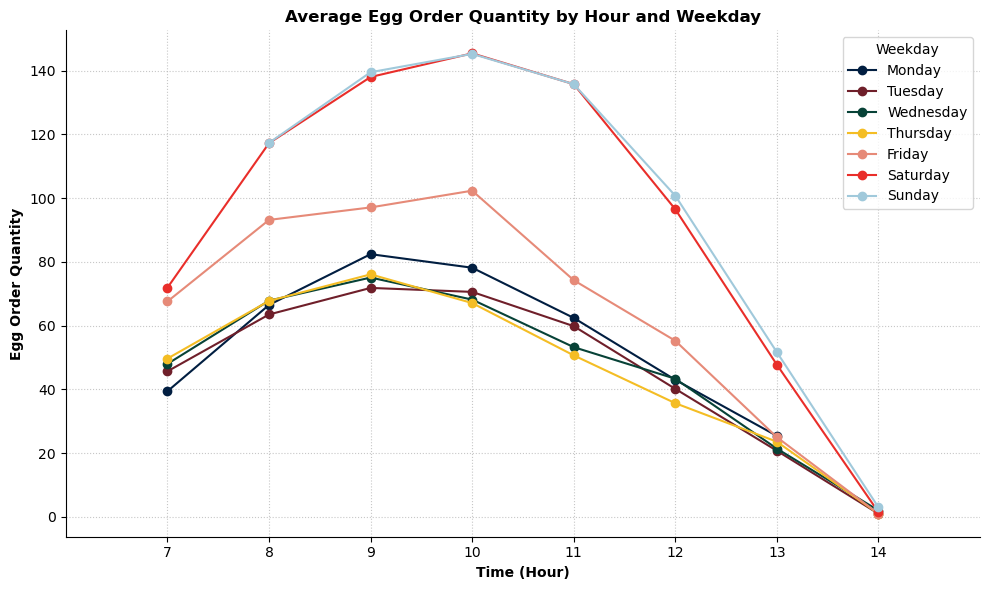

In [657]:
weekdays = list(range(7))


weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_colors = {weekday: doz_pal[i % len(doz_pal)] for i, weekday in enumerate(weekdays)}


fig, ax = plt.subplots(figsize=(10, 6))

for weekday in weekdays:
    weekday_data = group_egg[group_egg['weekday'] == weekday]
    hourly_means = weekday_data.groupby('hour')['qty'].mean()
    
    
    ax.plot(hourly_means.index, hourly_means.values, label=weekday_names[weekday], marker='o', color=weekday_colors[weekday])


ax.set_xlabel('Time (Hour)', fontweight="bold")
ax.set_ylabel('Egg Order Quantity', fontweight="bold")
ax.set_title('Average Egg Order Quantity by Hour and Weekday', fontweight="bold")
 

ax.set_xlim(6, 15)
ax.set_xticks(range(7, 15))


ax.legend(title='Weekday')
ax.grid(True, linestyle='dotted', alpha=0.7)


sns.despine()
plt.tight_layout()
#plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_chartsEgg_Orders_Weekday_Hour.png')


# Pastry Purchases Hourly Trends

In [659]:
df_pastry = idf.loc[
    (idf['category'] == 'pastry') &  
    (idf['category'] != 'staff meal/bev') ] 

group_pastry = df_pastry.groupby(['month','weekday','hour']).agg({'qty':'sum'}).reset_index()

group_pastry

,month,weekday,hour,qty
0,April,0,7,223.0
1,April,0,8,380.0
2,April,0,9,356.0
3,April,0,10,665.0
4,April,0,11,199.0
...,...,...,...,...
957,September,6,13,224.0
958,September,6,14,19.0
959,September,6,19,7.0
960,September,6,20,5.0


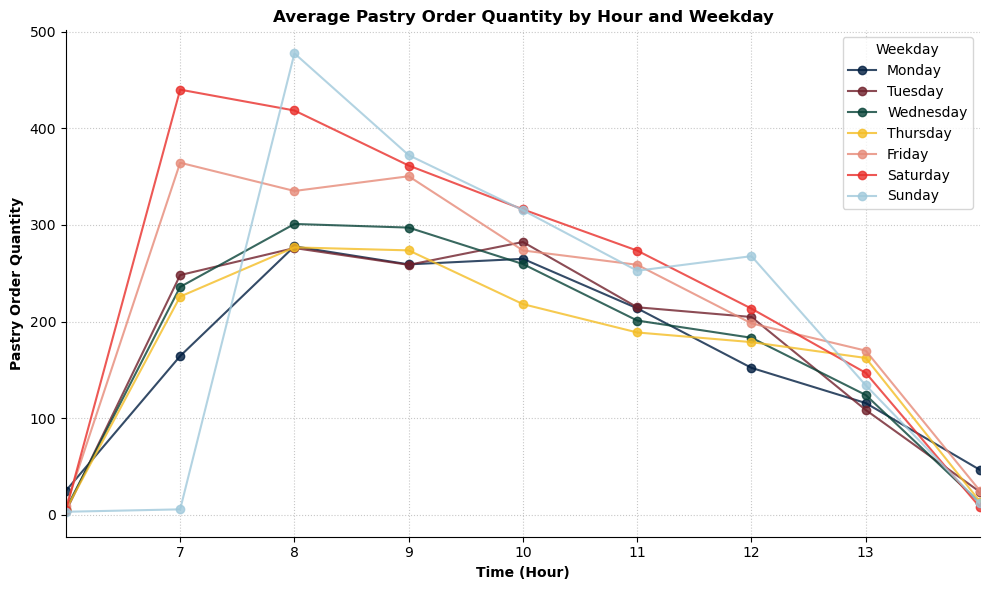

In [660]:
weekday_colors = {weekday: doz_pal[i % len(doz_pal)] for i, weekday in enumerate(weekdays)}

fig, ax = plt.subplots(figsize=(10, 6))

for weekday in weekdays:
    weekday_data = group_pastry[group_pastry['weekday'] == weekday]
    hourly_means = weekday_data.groupby('hour')['qty'].mean()
    
    ax.plot(hourly_means.index, hourly_means.values, label=weekday_names[weekday], marker='o', color=weekday_colors[weekday],alpha=.8)

ax.set_xlabel('Time (Hour)',fontweight="bold")

ax.set_ylabel('Pastry Order Quantity',fontweight="bold")
ax.set_title('Average Pastry Order Quantity by Hour and Weekday',fontweight="bold")
 
ax.set_xlim(6, 14)
ax.set_xticks(range(7, 14))
ax.legend(title='Weekday')
ax.grid(True, linestyle='dotted', alpha=0.7)
sns.despine()
plt.tight_layout()
##plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/avg_pastry_hour_weekday.png')

In [661]:
crois_types = croiz.item.to_list()


/var/folders/q1/g8w_03zs6gvbwv16kzb3fvk80000gn/T/ipykernel_1297/844283735.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(croiz,
/var/folders/q1/g8w_03zs6gvbwv16kzb3fvk80000gn/T/ipykernel_1297/844283735.py:10: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  sns.barplot(croiz,


Text(0.5, 1.0, 'TOP CROISSANT TYPES')

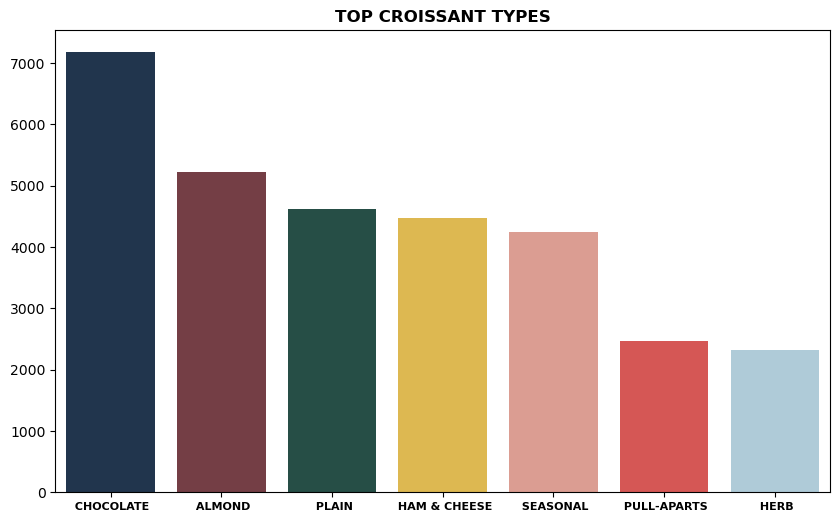

In [662]:
pop_pastry = df_pastry['item'].value_counts().to_frame().reset_index()


fig, ax = plt.subplots(figsize=(10, 6))

crois = df_pastry[df_pastry['item'].str.contains('^croissant', regex=True)] 
cookies = df_pastry[df_pastry['item'].str.contains('^cookie', regex=True)] 
croiz = crois.item.value_counts().to_frame().reset_index()

sns.barplot(croiz,
            x=croiz.item.str.slice(11).str.upper(),
            y='count',
            palette=doz_pal,alpha=0.9)

plt.xticks(rotation=0,fontsize=8,fontweight='bold')
plt.xlabel('')
plt.ylabel('')

plt.title('TOP CROISSANT TYPES',fontweight='bold')
#plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/popular_crois.png')

/var/folders/q1/g8w_03zs6gvbwv16kzb3fvk80000gn/T/ipykernel_1297/3180900519.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(popular_pastries,
/var/folders/q1/g8w_03zs6gvbwv16kzb3fvk80000gn/T/ipykernel_1297/3180900519.py:25: UserWarning: 
The palette list has fewer values (9) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(popular_pastries,


Text(0.5, 0, 'AMOUNT SOLD IN 2024')

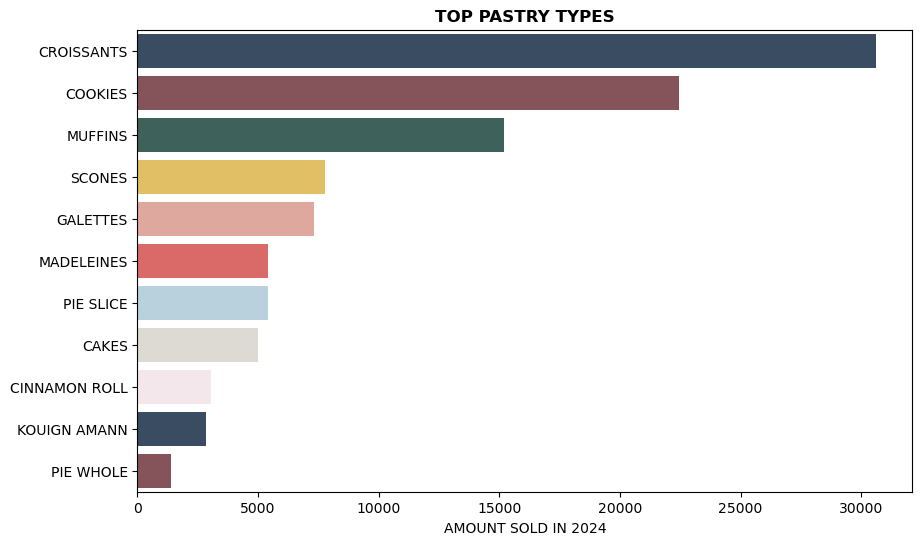

In [663]:


filter_pop = pop_pastry.groupby('item').sum().sort_values(by='count',ascending=False).reset_index()

filter_pop.item = filter_pop.item.apply(lambda x: 'croissants' if 'croissant' in x else x)

filter_pop.item = filter_pop.item.apply(
    lambda x: 'cookies' if any(substring in x for substring in ['cookie', 'shortbread','blondie','bars','gingerbread']) else x)

filter_pop.item = filter_pop.item.apply(lambda x: 'cakes' if 'cake' in x else x)

filter_pop.item = filter_pop.item.apply(lambda x: 'galettes' if 'galette' in x else x)

filter_pop.item = filter_pop.item.apply(lambda x: 'pie slice' if 'pie - slice' in x else x)

filter_pop.item = filter_pop.item.apply(lambda x: 'pie whole' if 'pie - whole' in x else x)

filter_pop.item = filter_pop.item.apply(lambda x: 'madeleines' if 'madeleine' in x else x)
filter_pop = filter_pop.groupby('item').sum().sort_values(by='count',ascending=False).reset_index()




popular_pastries = filter_pop.head(11)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(popular_pastries,
            y=popular_pastries['item'].str.upper(),
            x='count',
            palette=doz_pal,
            alpha=.8,
           orient = 'h')
plt.xticks(fontweight='light')
plt.ylabel('')
plt.title('TOP PASTRY TYPES',fontweight='bold')
plt.xlabel('AMOUNT SOLD IN 2024')
#plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/top_past.png')


# Bread Purchases Hourly Trends

In [666]:
monthly_bread = group_bread.groupby(['month','item'])['qty'].max().to_frame()
monthly_bread.sort_values(by='qty',ascending=False)


NameError: name 'group_bread' is not defined

In [ ]:
df_bread = idf.loc[
    (idf['category'] == 'bread') &  
    (idf['category'] != 'staff meal/bev') ] 

group_bread = df_bread.groupby(['month','weekday','hour','item']).agg({'qty':'sum'}).reset_index()



In [ ]:
weekday_colors = {weekday: doz_pal[i % len(doz_pal)] for i, weekday in enumerate(weekdays)}

fig, ax = plt.subplots(figsize=(10, 6))

for weekday in weekdays:
    weekday_data = group_bread[group_bread['weekday'] == weekday]
    hourly_means = weekday_data.groupby('hour')['qty'].mean()
    
    ax.plot(hourly_means.index, hourly_means.values, label=weekday_names[weekday], marker='o', color=weekday_colors[weekday])

ax.set_xlabel('Time (Hour)',fontweight="bold")

ax.set_ylabel('Bread Order Quantity',fontweight="bold")
ax.set_title('Average Bread Order Quantity by Hour and Weekday',fontweight="bold")
 
ax.set_xlim(6, 14)
ax.set_xticks(range(7, 14))
ax.legend(title='Weekday')
ax.grid(True, linestyle='dotted', alpha=0.7)
sns.despine()
plt.tight_layout()
##plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/bread_hours_weekdays.png')

In [ ]:
filter_bread = df_bread['item'].value_counts().to_frame().reset_index()


filter_bread.item = filter_bread.item.apply(lambda x: 'challah' if 'challah' in x else x)
filter_bread.item = filter_bread.item.apply(lambda x: 'umami' if 'umami' in x else x)
filter_bread.item = filter_bread.item.apply(lambda x: 'foccacia' if 'focaccia' in x else x)
filter_bread.item = filter_bread.item.apply(lambda x: '7-grain ' if '7-grain' in x else x)
filter_bread.item = filter_bread.item.apply(lambda x: 'olive+herb ' if 'olive' in x else x)
filter_bread.item = filter_bread.item.apply(lambda x: 'oatmeal ' if 'oatmeal' in x else x)
filter_bread.item = filter_bread.item.apply(lambda x: 'french country ' if 'french' in x else x)
filter_bread.item = filter_bread.item.apply(lambda x: 'white sando bread' if 'white sourdough sandwich' in x else x)
filter_bread_grouped = filter_bread.groupby('item').sum().reset_index()
filter_bread_grouped  =filter_bread_grouped.sort_values(by='count',ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=filter_bread_grouped.head(9),
    x='count',
    y=filter_bread_grouped.head(9).item.str.upper(),
    orient='h',
    palette=doz_pal,
    
    )

plt.ylabel('')
plt.xlabel('AMOUNT SOLD IN 2024')
plt.title('TOP BREAD TYPES',fontweight= 'bold')
plt.tight_layout()
#plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/top_bread_types.png')

# Retail Purchases Hourly by Weekday

In [ ]:
df_retail = idf.loc[
    (idf['category'] == 'retail') &  
    (idf['category'] != 'staff meal/bev') ] 

group_retail = df_retail.groupby(['month','weekday','hour']).agg({'qty':'sum'}).reset_index()



weekday_colors = {weekday: doz_pal[i % len(doz_pal)] for i, weekday in enumerate(weekdays)}

fig, ax = plt.subplots(figsize=(10, 6))

for weekday in weekdays:
    weekday_data = group_retail[group_retail['weekday'] == weekday]
    hourly_means = weekday_data.groupby('hour')['qty'].mean()
    
    ax.plot(hourly_means.index, hourly_means.values, label=weekday_names[weekday], marker='o', color=weekday_colors[weekday])

ax.set_xlabel('Time (Hour)',fontweight="bold")

ax.set_ylabel('retail Order Quantity',fontweight="bold")
ax.set_title('Average Retail Order Quantity by Hour and Weekday',fontweight="bold")
 
ax.set_xlim(6, 14)
ax.set_xticks(range(7, 14))
ax.legend(title='Weekday')
ax.grid(True, linestyle='dotted', alpha=0.7)
sns.despine()
plt.tight_layout()

#plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/retail_orders_hourly.png')

In [ ]:
retail_pop = df_retail.item.value_counts().head(6).to_frame().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=retail_pop,
            x=retail_pop.item.str.upper(),
            y='count',
            palette=doz_pal) 

plt.title(' MOST POPULAR RETAIL ITEMS',fontweight='bold')
plt.xticks(fontweight='bold',fontsize=8)
plt.xlabel('')
plt.ylabel('')

##plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/pop_retail.png')

# Breakfast Hourly Trends

In [ ]:
df_breakfast = idf.loc[
    (idf['category'] == 'breakfast') &  
    (idf['category'] != 'staff meal/bev') ] 

group_breakfast = df_retail.groupby(['month','weekday','hour']).agg({'qty':'sum'}).reset_index()



weekday_colors = {weekday: doz_pal[i % len(doz_pal)] for i, weekday in enumerate(weekdays)}

fig, ax = plt.subplots(figsize=(10, 6))

for weekday in weekdays:
    weekday_data = group_breakfast[group_breakfast['weekday'] == weekday]
    hourly_means = weekday_data.groupby('hour')['qty'].mean()
    
    ax.plot(hourly_means.index, hourly_means.values, label=weekday_names[weekday], marker='o', color=weekday_colors[weekday])

ax.set_xlabel('Time (Hour)',fontweight="bold")

ax.set_ylabel('Breakfast Order Quantity',fontweight="bold")
ax.set_title('Average Breakfast Order Quantity by Hour and Weekday',fontweight="bold")
 
ax.set_xlim(6, 14)
ax.set_xticks(range(7, 14))
ax.legend(title='Weekday')
ax.grid(True, linestyle='dotted', alpha=0.7)
sns.despine()
plt.tight_layout()

##plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/breakfast_hourly.png')

# Lunch Purchases Hourly Trends

In [ ]:
df_lunch = idf.loc[
    (idf['category'] == 'lunch') &  
    (idf['category'] != 'staff meal/bev') ] 

group_lunch = df_lunch.groupby(['month','weekday','hour']).agg({'qty':'sum'}).reset_index()



weekday_colors = {weekday: doz_pal[i % len(doz_pal)] for i, weekday in enumerate(weekdays)}

fig, ax = plt.subplots(figsize=(10, 6))

for weekday in weekdays:
    weekday_data = group_lunch [group_lunch ['weekday'] == weekday]
    hourly_means = weekday_data.groupby('hour')['qty'].mean()
    
    ax.plot(hourly_means.index, hourly_means.values, label=weekday_names[weekday], marker='o', color=weekday_colors[weekday])

ax.set_xlabel('Time (Hour)',fontweight="bold")

ax.set_ylabel('Lunch Order Quantity',fontweight="bold")
ax.set_title('Average Lunch Order Quantity by Hour and Weekday',fontweight="bold")
 
ax.set_xlim(6, 14)
ax.set_xticks(range(7, 14))
ax.legend(title='Weekday')
ax.grid(True, linestyle='dotted', alpha=0.7)
sns.despine()
plt.tight_layout()

#plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/lunch_orders.png')

In [ ]:
lunch_pop = df_lunch.item.value_counts().head(6).to_frame().reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=retail_pop,
            x=lunch_pop.item.str.upper(),
            y='count',
            palette=doz_pal,
          )
plt.title(' MOST POPULAR LUNCH ITEMS',fontweight='bold')
plt.xticks(fontweight='bold',fontsize=8)
plt.xlabel('')
plt.ylabel('')

#plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/pop_lunch.png')

# Savory Retail Hourly Purchases

In [ ]:
df_sav_retail = idf.loc[
    (idf['category'] == 'savory retail') &  
    (idf['category'] != 'staff meal/bev') ] 

group_sav_retail = df_sav_retail.groupby(['month','weekday','hour']).agg({'qty':'sum'}).reset_index()



weekday_colors = {weekday: doz_pal[i % len(doz_pal)] for i, weekday in enumerate(weekdays)}

fig, ax = plt.subplots(figsize=(10, 6))

for weekday in weekdays:
    weekday_data = group_sav_retail [group_sav_retail ['weekday'] == weekday]
    hourly_means = weekday_data.groupby('hour')['qty'].mean()
    
    ax.plot(hourly_means.index, hourly_means.values, label=weekday_names[weekday], marker='o', color=weekday_colors[weekday])

ax.set_xlabel('Time (Hour)',fontweight="bold")

ax.set_ylabel('Savory Retail Order Quantity',fontweight="bold")
ax.set_title('Average Savory Retail Order Quantity by Hour and Weekday',fontweight="bold")
 
ax.set_xlim(6, 14)
ax.set_xticks(range(7, 14))
ax.legend(title='Weekday')
ax.grid(True, linestyle='dotted', alpha=0.7)
sns.despine()
plt.tight_layout()

##plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/savory_retail_hourly.png')

In [ ]:
filter_sav_retail = df_sav_retail.item.value_counts().to_frame().reset_index()

filter_sav_retail.item = filter_sav_retail.item.apply(lambda x: 'pot pies' if 'pot pie' in x else x)
filter_sav_retail.item = filter_sav_retail.item.apply(lambda x: 'granolas' if 'granola' in x else x)
filter_sav_retail.item = filter_sav_retail.item.apply(lambda x: 'butters' if 'butter' in x else x)
filter_sav_retail.item = filter_sav_retail.item.apply(lambda x: 'casseroles' if 'casserole' in x else x)
filter_sav_retail.item = filter_sav_retail.item.apply(lambda x: 'sauces' if 'sauce' in x else x)
filter_sav_retail.item = filter_sav_retail.item.apply(lambda x: 'sauces' if 'sauce' in x else x)
filter_sav_retail.item = filter_sav_retail.item.apply(lambda x: 'sauces' if 'gravy' in x else x)
filter_sav_retail.item = filter_sav_retail.item.apply(lambda x: 'soups' if 'soup' in x else x)
filter_sav_retail.item = filter_sav_retail.item.apply(
    lambda x: 'sandwiches' if any(substring in x for substring in ['slider', 'sandwiches']) else x)





filtered_sav_retail = filter_sav_retail.groupby('item').sum().reset_index()
filtered_sav_retail = filtered_sav_retail.sort_values('count',ascending=False).reset_index(drop=True).head(8)
filtered_sav_retail

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=filtered_sav_retail,
            x=filtered_sav_retail.item.str.upper(),
            y='count',
            palette=doz_pal,
            alpha=.8)
plt.title(' MOST POPULAR SAVORY RETAIL ITEMS',fontweight='bold')
plt.xticks(fontweight='bold',fontsize=8)
plt.xlabel('')
plt.ylabel('')

##plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/pop_sav_retail.png')

# Beverages Hourly Purchases

In [ ]:
df_bev = idf.loc[
    (idf['category'] == 'beverages') &  
    (idf['category'] != 'staff meal/bev') ] 

group_bev = df_bev.groupby(['month','weekday','hour','item']).agg({'qty':'sum'}).reset_index()



weekday_colors = {weekday: doz_pal[i % len(doz_pal)] for i, weekday in enumerate(weekdays)}

fig, ax = plt.subplots(figsize=(10, 6))

for weekday in weekdays:
    weekday_data = group_bev [group_bev ['weekday'] == weekday]
    hourly_means = weekday_data.groupby('hour')['qty'].mean()
    
    ax.plot(hourly_means.index, hourly_means.values, label=weekday_names[weekday], marker='o', color=weekday_colors[weekday])

ax.set_xlabel('Time (Hour)',fontweight="bold")

ax.set_ylabel('Average Beverage Order Quantity',fontweight="bold")
ax.set_title('Average Beverage Order Quantity by Hour and Weekday',fontweight="bold")
 
ax.set_xlim(6, 14)
ax.set_xticks(range(7, 14))
ax.legend(title='Weekday')
ax.grid(True, linestyle='dotted', alpha=0.7)
sns.despine()
plt.tight_layout()

#plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/bev_Orders_Weekday_Hour.png')

In [ ]:
filtered_bev = df_bev.item.value_counts().to_frame().reset_index()

filtered_bev.item = filtered_bev.item.apply(lambda x: 'sodas' if 'soda' in x else x)
filtered_bev.item = filtered_bev.item.apply(lambda x: 'teas' if 'tea' in x else x)
filtered_bev.item = filtered_bev.item.apply(lambda x: 'teas' if 'chai' in x else x)
filtered_bev.item = filtered_bev.item.apply(lambda x: 'seasonal' if 'seasonal' in x else x)
filtered_bev.item = filtered_bev.item.apply(lambda x: 'esp+milk' if 'mocha' in x else x)
filtered_bev.item = filtered_bev.item.apply(lambda x: 'esp+milk' if 'espresso' in x else x)
filtered_bev.item = filtered_bev.item.apply(lambda x: 'orange juice' if 'orange' in x else x)
filtered_bev.item = filtered_bev.item.apply(lambda x: 'drip coffee' if 'coffee' in x else x)
filtered_bev.item = filtered_bev.item.apply(
    lambda x: 'milks' if any(substring in x for substring in ['cinnamon', 'chocolate','(glass)']) else x)


In [ ]:
filtered_bev = filtered_bev.groupby('item').sum().reset_index()
filtered_bevs = filtered_bev.sort_values("count",ascending=False).reset_index(drop=True).head(15)
filtered_bevs = filtered_bevs.head(7)

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=filtered_bevs,
            y=filtered_bevs.item.str.upper(),
            x='count',
            palette=doz_pal,
            
            orient ='h')
plt.title(' TOP BEVERAGES',fontweight='bold')
plt.xticks(fontweight='bold',fontsize=8)
plt.xlabel('AMOUNT SOLD IN 2024')
plt.ylabel('')

#plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/pop_bev.png')

# Category Sales Trends by Hour/Week/Month

In [ ]:
hourly_sales_cat = idf.groupby(['month','weekday',idf.index.hour, 'category',])['gross_sales'].sum().unstack(fill_value=0)
hourly_sales_cat = hourly_sales_cat.drop(columns=['staff meal/bev'])

cat_sum_monthly = hourly_sales_cat.groupby('month').sum()


month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


cat_sum_monthly.index = pd.CategoricalIndex(cat_sum_monthly.index, categories=month_order, ordered=True)


cat_sum_monthly = cat_sum_monthly.sort_index()
cat_sum_monthly
cat_sum_monthly.columns = cat_sum_monthly.columns.str.upper()

category_colors = {category: doz_pal[i % len(doz_pal)] for i, category in enumerate(cat_sum_monthly.columns)}

fig, ax = plt.subplots(figsize=(11, 6))


for category in cat_sum_monthly.columns:
    ax.plot(cat_sum_monthly.index, cat_sum_monthly[category], label=category, marker='o', color=category_colors[category],alpha=.6)

ax.set_xlabel('')
ax.set_ylabel('Gross Sales', fontweight="bold")
ax.set_title('', fontweight="bold")


ax.set_xticks(range(len(cat_sum_monthly.index)))
ax.set_xticklabels(cat_sum_monthly.index.str.upper(), rotation=40, ha="right",fontweight='bold',fontsize=8)

ax.legend(title='Category', loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=True, ncol=7)



ax.grid(True, linestyle='dotted', alpha=0.7)
sns.despine()
plt.tight_layout()


#plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/gross_sales_by_cat.png')


# Discounts

In [691]:
discounts_total = df['discounts'].sum()
print(f'2024 total discounts equaled out to ${discounts_total.round(0)}')

2024 total discounts equaled out to $118547.0


In [701]:
avg_disc_month = discounts_by_month.discounts.mean().round(0)
print(f'Throughout 2024, the monthly average of discounts given was ${avg_disc_month}')

Throughout 2024, the monthly average of discounts given was $-9879.0


/var/folders/q1/g8w_03zs6gvbwv16kzb3fvk80000gn/T/ipykernel_1297/3092468285.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=discounts_by_month, x='month', y='discounts', palette= doz_pal)
/var/folders/q1/g8w_03zs6gvbwv16kzb3fvk80000gn/T/ipykernel_1297/3092468285.py:14: UserWarning: 
The palette list has fewer values (9) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=discounts_by_month, x='month', y='discounts', palette= doz_pal)


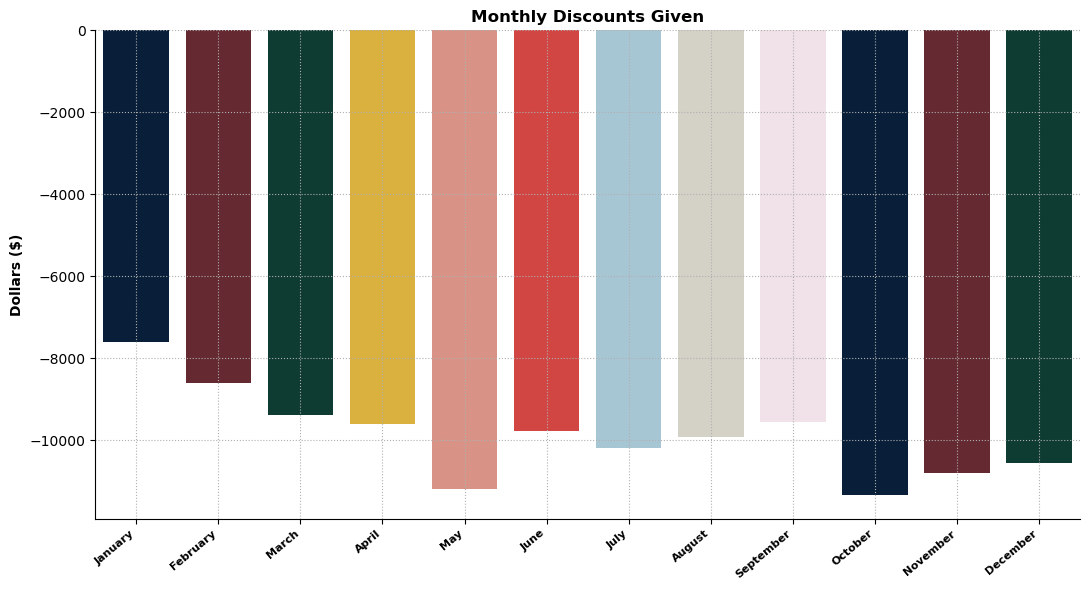

In [687]:
discounts_by_month = df.groupby('month')['discounts'].sum().to_frame().sort_values(by='discounts',ascending=False).reset_index()
discounts_by_month
discounts_by_month['discounts'] = discounts_by_month['discounts'] * -1

discounts_by_month['month'] = pd.Categorical(discounts_by_month['month'], categories=month_order, ordered=True)


discounts_by_month = discounts_by_month.sort_values('month')




plt.figure(figsize=(11, 6))
sns.barplot(data=discounts_by_month, x='month', y='discounts', palette= doz_pal)

plt.xlabel('')
plt.ylabel('Dollars ($)', fontweight='bold')
plt.title('Monthly Discounts Given', fontweight='bold')
plt.xticks(rotation=40, ha="right", fontweight='bold', fontsize=8)
plt.grid(True, linestyle='dotted')
sns.despine()

plt.tight_layout()


plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/monthly_discounts.png')

# Net Sales

In [89]:
sales_total = df['net_sales'].sum()
print(f'2024 total sales from the front of house equaled out to ${sales_total.round(0)}')

2024 total sales from the front of house equaled out to $2224306.0


In [693]:
sales_by_month = df.groupby('month')['gross_sales'].sum().to_frame().reset_index().sort_values(by='gross_sales',ascending=False)

In [695]:
sales_by_month = sales_by_month.reset_index(drop=True)

In [705]:
sales_by_month.gross_sales.mean()


195151.6875

/var/folders/q1/g8w_03zs6gvbwv16kzb3fvk80000gn/T/ipykernel_1297/1970134056.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_month, x='month', y='gross_sales', palette= doz_pal,alpha=.8)
/var/folders/q1/g8w_03zs6gvbwv16kzb3fvk80000gn/T/ipykernel_1297/1970134056.py:8: UserWarning: 
The palette list has fewer values (9) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=sales_by_month, x='month', y='gross_sales', palette= doz_pal,alpha=.8)


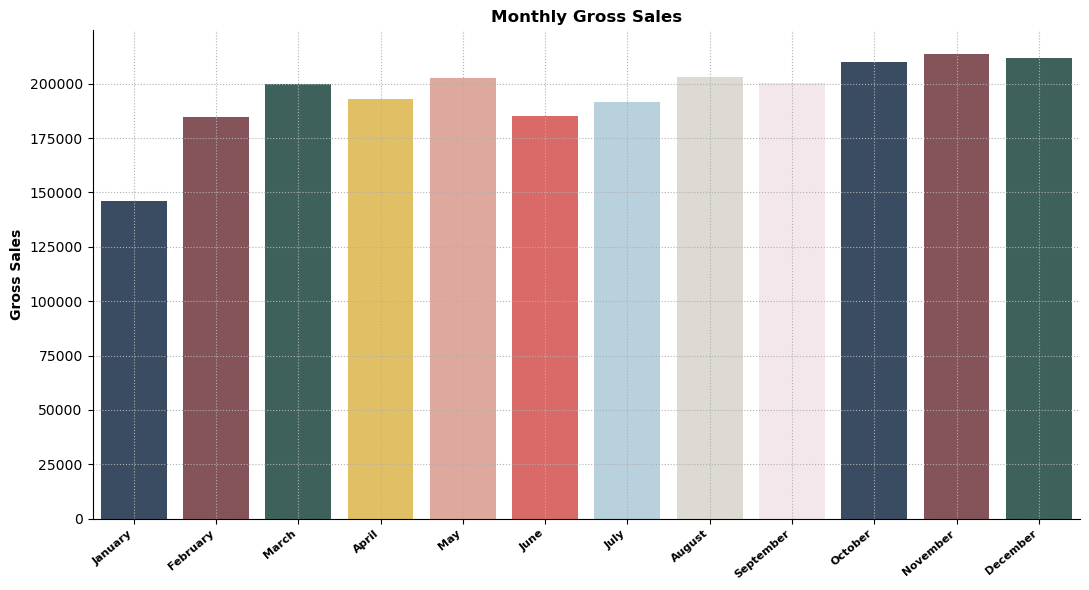

In [709]:
sales_by_month['month'] = pd.Categorical(sales_by_month['month'], categories=month_order, ordered=True)


sales_by_month = sales_by_month.sort_values('month')


plt.figure(figsize=(11, 6))
sns.barplot(data=sales_by_month, x='month', y='gross_sales', palette= doz_pal,alpha=.8)

plt.xlabel('')
plt.ylabel('Gross Sales', fontweight='bold')
plt.title('Monthly Gross Sales', fontweight='bold')
plt.xticks(rotation=40, ha="right", fontweight='bold', fontsize=8)
plt.grid(True, linestyle='dotted')
sns.despine()
plt.tight_layout()


plt.savefig('/Users/jonathanfarro/Documents/Dozen Bakery Project/dozenbakeryproject/notebooks/final_charts/gross_sales_monthly.png')

In [689]:
df

,date_time,time_12hr,customer_name,category,item,qty,desc,modifiers_applied,gross_sales,discounts,net_sales,tax,notes,weekday,month,date,time,hour,has_egg
0,2024-01-03 09:48:42,09:48 AM,"lindsay decarlo, lindsay decarlo",pastry,sandwich cookie,30.0,linzer,0,120.00,0.00,120.00,11.10,0,2,January,2024-01-03,09:48:42,9,False
1,2024-01-04 11:20:43,11:20 AM,0,retail,puzzles,1.0,piecework 1000 pc puzzle (assorted designs),0,35.00,8.75,26.25,2.43,0,3,January,2024-01-04,11:20:43,11,False
2,2024-01-04 15:14:54,03:14 PM,katherine hyde,pastry,pastry,5.0,scone,0,17.50,0.00,17.50,1.62,0,3,January,2024-01-04,15:14:54,15,False
3,2024-01-04 15:14:54,03:14 PM,katherine hyde,pastry,pastry,2.0,croissant - almond,0,10.00,0.00,10.00,0.93,0,3,January,2024-01-04,15:14:54,15,False
4,2024-01-04 15:14:54,03:14 PM,katherine hyde,pastry,pastry,2.0,croissant - chocolate,0,9.00,0.00,9.00,0.83,0,3,January,2024-01-04,15:14:54,15,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321127,2024-12-31 16:07:31,04:07 PM,jentry leach,pastry,croissant - chocolate,1.0,0,0,4.50,0.00,4.50,0.42,a classic chocolate croissant made with dark c...,1,December,2024-12-31,16:07:31,16,True
321128,2024-12-31 16:07:31,04:07 PM,jentry leach,pastry,croissant - ham & cheese,1.0,0,0,4.75,0.00,4.75,0.44,"black forest ham, baby swiss cheese and whole-...",1,December,2024-12-31,16:07:31,16,True
321129,2024-12-31 16:07:31,04:07 PM,jentry leach,pastry,cookies,1.0,ginger,0,2.50,0.00,2.50,0.23,"chocolate chip (contains wheat, dairy & eggs)\...",1,December,2024-12-31,16:07:31,16,True
321130,2024-12-31 16:07:31,04:07 PM,jentry leach,bread,sourdough starter,1.0,regular,0,0.00,0.00,0.00,0.00,free with any purchase - just add this your ca...,1,December,2024-12-31,16:07:31,16,False
